<a href="https://colab.research.google.com/github/guntsvzz/CP_Project/blob/main/EEG_Stress_LSTM_Chunking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [ ]:
!gdown --id 1KZjrJfUrB_k1g8VUsohNpek_hvWNqGcr

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:125: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1KZjrJfUrB_k1g8VUsohNpek_hvWNqGcr
To: /content/Clean_signal.zip
100% 113M/113M [00:02<00:00, 43.7MB/s]


In [ ]:
!unzip '/content/Clean_signal.zip'
#!mv '/content/clean_exp16' 'Cleaned_signal'

Archive:  /content/Clean_signal.zip
   creating: Clean_signal/
  inflating: __MACOSX/._Clean_signal  
  inflating: Clean_signal/PSS10 - Sheet1.csv  
  inflating: __MACOSX/Clean_signal/._PSS10 - Sheet1.csv  
  inflating: Clean_signal/clean_exp08.csv  
  inflating: __MACOSX/Clean_signal/._clean_exp08.csv  
  inflating: Clean_signal/clean_exp09.csv  
  inflating: __MACOSX/Clean_signal/._clean_exp09.csv  
  inflating: Clean_signal/clean_exp01.csv  
  inflating: __MACOSX/Clean_signal/._clean_exp01.csv  
  inflating: Clean_signal/clean_exp15.csv  
  inflating: __MACOSX/Clean_signal/._clean_exp15.csv  
  inflating: Clean_signal/clean_exp14.csv  
  inflating: __MACOSX/Clean_signal/._clean_exp14.csv  
  inflating: Clean_signal/clean_exp16.csv  
  inflating: __MACOSX/Clean_signal/._clean_exp16.csv  
  inflating: Clean_signal/clean_exp02.csv  
  inflating: __MACOSX/Clean_signal/._clean_exp02.csv  
  inflating: Clean_signal/clean_exp03.csv  
  inflating: __MACOSX/Clean_signal/._clean_exp03.csv  
 

In [ ]:
pip install mne

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 8.9 MB/s 


In [ ]:
pip install components

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pickle
import numpy as np
import os
import mne
import pandas as pd
pickle.format_version

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms  
from torch.utils.data import DataLoader, Dataset  
from torch.utils.data import TensorDataset
from torch.autograd import Variable

import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# setting seed so that splitting process and training process can be reproduce
torch.manual_seed(1)

# ETL

In [ ]:
import os
main_path = os.getcwd()
filename = os.listdir(main_path + '/Clean_signal/')

In [ ]:
filename = ['clean_exp01.csv',
 'clean_exp02.csv',
 'clean_exp03.csv',
 'clean_exp04.csv',
 'clean_exp05.csv',
 'clean_exp06.csv',
 'clean_exp07.csv',
 'clean_exp08.csv',
 'clean_exp09.csv',
 'clean_exp10.csv',
 'clean_exp11.csv',
 'clean_exp12.csv',
 'clean_exp13.csv',
 'clean_exp14.csv',
 'clean_exp15.csv',
 'clean_exp16.csv',
 'clean_exp17.csv']

In [ ]:
all_file_path = main_path + '/Clean_signal/'
X_list = list()
for file in filename:
    file_path = all_file_path + file
    df = pd.read_csv(file_path, index_col=None)
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    X_list.append(df)  

In [ ]:
df.head()

,Fp1,Fp2,F7,F3,F4,F8,T3,C3,C4,T4,T5,P3,P4,T6,O1,O2
0,1.558541e-13,1.202787e-12,-1.822815e-12,-6.666149e-13,-1.524659e-14,-9.656176e-14,1.778769e-13,-7.318365e-13,-3.218725e-14,6.776264e-15,2.463172e-12,-5.293956e-13,1.679243e-13,2.774456e-12,-3.303428e-13,2.217109e-13
1,-2.495299e+02,-2.591266e+02,-2.392414e+02,-2.472481e+02,-1.342918e+02,-2.469675e+02,-2.368676e+02,-2.375381e+02,8.964020e+01,9.114929e+01,9.105020e+01,7.684951e+01,1.383037e+02,-4.155527e+02,-3.083336e+02,-1.145710e+02
2,-1.022146e+02,-1.071695e+02,-8.913196e+01,-9.320015e+01,-7.188064e+01,-9.669399e+01,-7.360927e+01,-7.934479e+01,-8.483305e+00,-3.966042e+00,6.921319e-02,-5.860820e+00,6.340924e+00,-1.006591e+02,-7.385641e+01,-3.186257e+01
3,-1.894707e+02,-1.985657e+02,-1.666088e+02,-1.773347e+02,-1.206077e+02,-1.861381e+02,-1.566157e+02,-1.616160e+02,1.053098e+01,1.359837e+01,2.570865e+01,1.375228e+01,4.319836e+01,-2.383818e+02,-1.751361e+02,-7.472951e+01
4,-1.976600e+02,-2.088452e+02,-1.691085e+02,-1.829386e+02,-1.219805e+02,-1.981792e+02,-1.664133e+02,-1.711082e+02,5.430791e+00,5.540176e+00,2.039321e+01,9.522058e+00,4.153111e+01,-2.713544e+02,-1.985949e+02,-9.082392e+01


In [53]:
X = np.array(X_list)
X.shape

(17, 45000, 16)

In [54]:
# Reshape
X = np.transpose(X, (0, 2, 1))
X.shape

(17, 16, 45000)

In [46]:
def vectorized_windowing(arr, window_len, overlap_len=None):
    '''
    Sliding window without using loop
    '''
    seq_len = arr.shape[-1]
    
    if not overlap_len:
        overlap_len = window_len

    n_sliding_windows = ((seq_len - window_len) // overlap_len) + 1

    sub_windows = np.array([np.arange(window_len)]) + np.array([np.arange(n_sliding_windows) * overlap_len]).T

    slided_arr = arr[..., sub_windows]

    return slided_arr


In [110]:
X_chunked = vectorized_windowing(X, window_len=4500)
X_chunked = np.swapaxes(X_chunked,1,2).reshape(-1, 16, 4500)

print(X_chunked.shape)

X = X_chunked.copy()

(170, 16, 4500)


In [111]:
y_path = '/content/Clean_signal/PSS10 - Sheet1.csv'
df = pd.read_csv(y_path)
y = np.array(df['label'])
y

array([1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1])

In [112]:
y_chunked = np.repeat(y, 10)

y = y_chunked.copy()

# Split Data

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=999)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(119, 16, 4500) (51, 16, 4500) (119,) (51,)


In [114]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=999)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(95, 16, 4500) (24, 16, 4500) (95,) (24,)


In [115]:
from sklearn.preprocessing import MinMaxScaler

#scale transform each channel independently
scalers = {}
for i in range(X_train.shape[2]):
    scalers[i] = MinMaxScaler(feature_range=(-1, 1))
    X_train[:, :, i] = scalers[i].fit_transform(X_train[:, :, i]) 

for i in range(X_val.shape[2]):
    X_val[:, :, i]   = scalers[i].transform(X_val[:, :, i])     
    
for i in range(X_test.shape[2]):
    X_test[:, :, i]  = scalers[i].transform(X_test[:, :, i]) 

In [116]:
print(X_train.mean(), X_val.mean(), X_test.mean())
print(X_train.min(), X_val.min(), X_test.min())
print(X_train.max(), X_val.max(), X_test.max())

0.0041340678015943134 0.004544915739524798 0.004996261783145257
-1.0 -126.51391890653524 -178.70927104895114
1.0000000000000004 100.63342601739716 150.148802065768


# Define Batch size and train,test, val loader

In [117]:
X_train_tensor = torch.tensor(X_train).to(torch.float32)
y_train_tensor = torch.tensor(y_train).to(torch.float32)
X_val_tensor = torch.tensor(X_val).to(torch.float32)
y_val_tensor = torch.tensor(y_val).to(torch.float32)
X_test_tensor = torch.tensor(X_test).to(torch.float32)
y_test_tensor = torch.tensor(y_test).to(torch.float32)

# Cast data to dataloader for more convenience
training_set = TensorDataset(X_train_tensor, y_train_tensor)
testing_set = TensorDataset(X_test_tensor, y_test_tensor)
validation_set = TensorDataset(X_val_tensor, y_val_tensor)

train_batch_size = 5
val_batch_size = len(validation_set)
test_batch_size = len(testing_set)

train_loader = DataLoader(training_set, train_batch_size, shuffle=True)
val_loader = DataLoader(validation_set, val_batch_size, shuffle=True)
test_loader = DataLoader(testing_set, test_batch_size, shuffle=True)

In [118]:
for data, label in train_loader:
  print(data)
  break

tensor([[[ 1.8963e-01,  2.3987e-01, -1.3092e-01,  ..., -8.4178e-01,
          -4.4252e-01,  3.6788e-01],
         [ 1.9925e-01,  7.9905e-01,  3.4796e-01,  ..., -7.9627e-02,
           6.9404e-01,  3.1058e-01],
         [ 7.9168e-02, -2.8276e-01, -1.7003e-01,  ..., -8.1465e-01,
          -1.8025e-01,  2.2848e-01],
         ...,
         [ 5.2591e-01, -1.0236e-02, -3.4313e-01,  ..., -5.1625e-01,
          -7.0548e-01, -1.2015e-01],
         [ 9.8409e-01,  9.7980e-01,  9.7423e-01,  ..., -1.8743e-01,
          -1.0618e-01,  8.8028e-04],
         [ 8.4754e-01,  1.6825e-01,  2.5480e-01,  ...,  1.6644e-01,
          -3.2959e-01,  9.4383e-02]],

        [[ 2.4288e-01,  2.3583e-01, -8.8486e-02,  ..., -6.7673e-01,
          -2.9617e-01,  5.0984e-01],
         [ 2.3317e-01,  7.9145e-01,  3.7331e-01,  ...,  3.6393e-02,
           7.2555e-01,  5.6580e-01],
         [ 1.5791e-01, -2.7504e-01, -9.1806e-02,  ..., -6.5906e-01,
          -6.9142e-02,  3.4842e-01],
         ...,
         [ 5.3398e-01, -6

In [119]:
data.shape

torch.Size([5, 16, 4500])

In [120]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# LSTM model

In [121]:
class LSTM(nn.Module):
    '''
    Expected Input Shape: (batch, channels, seq_len, )
    '''
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, bidirectional, dropout):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, 
                           hidden_dim, 
                           num_layers=num_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout,
                           batch_first=True)
        self.fc = nn.Linear(hidden_dim * num_layers, output_dim)
        
    def forward(self, x):
        
        #x = [batch size, channels, seq len, ]
        out, (hn, cn) = self.lstm(x)
        
        #out = [batch size, seq len, hidden dim * num directions]        
        #hn = [num layers * num directions, batch size, hidden dim]
        #cn = [num layers * num directions, batch size, hidden dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        hn = torch.cat((hn[-2,:,:], hn[-1,:,:]), dim = 1)
        #hn = [batch size, hidden dim * num directions]
        
        return self.fc(hn)

In [122]:
#explicitly initialize weights for better learning
def initialize_weights(m):
    if isinstance(m, nn.Linear):   #if layer is of Linear
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):   #if layer is of LSTM
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.orthogonal_(param)  #orthogonal is a common way to initialize weights for RNN/LSTM/GRU

In [148]:
input_size     = 16 #channel 
hidden_size    = 256 
num_layers    = 2  
output_size    = 1  #we got 2 classes so we can output only 1 number, 0 for first class and 1 for another class
bidirectional = True  #uses bidirectional LSTM
dropout       = 0.5 

#define the model
model = LSTM(input_size, hidden_size, num_layers, output_size, bidirectional, dropout)

#send to cuda so we can use the GPU
model = model.to(device)  

#apply weights
model.apply(initialize_weights)

LSTM(
  (lstm): LSTM(16, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
)

In [149]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model {type(model).__name__} has {count_parameters(model):,} trainable parameters')# Train the model


The model LSTM has 2,138,625 trainable parameters


In [150]:
import torch.optim as optim

num_epochs = 20

lr = 0.001

optimizer = optim.Adam(model.parameters(), lr=lr) 
criterion = nn.BCEWithLogitsLoss() 

In [151]:
#for measuring accuracy
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc


In [152]:
torch.sigmoid(torch.tensor([[-1.1193],
        [-1.7878]]) )

tensor([[0.2461],
        [0.1433]])

In [153]:
#for timing the epochs
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [154]:
def train(model, train_loader,  optimizer, criterion):

    model.train()
    epoch_train_loss = 0
    epoch_train_acc  = 0

    for i, batch in enumerate(train_loader):
    
        # data shape: (batch, channel, seq len)
        data  = batch[0].to(device).permute(0, 2, 1)    
        # data shape: (batch, seq len, channel)

        # label shape: (batch, 1)
        label = batch[1].to(device).reshape(-1, 1)
        
        #predict
        output = model(data).reshape(-1, 1)  #output shape: (batch, 1)
        loss   = criterion(output, label)
        
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #for visualizing
        epoch_train_loss += loss.item()
        acc = binary_accuracy(output, label)
        epoch_train_acc += acc.item()
        
    epoch_train_loss = epoch_train_loss / len(train_loader)
    epoch_train_acc  = epoch_train_acc  / len(train_loader)
    
    return epoch_train_loss, epoch_train_acc


In [155]:
def evaluate(model, val_loader, criterion):

    model.eval()
    epoch_val_loss = 0
    epoch_val_acc  = 0

    with torch.no_grad():
        for i, batch in enumerate(val_loader):
            
            # data shape: (batch, channel, seq len)
            data  = batch[0].to(device).permute(0, 2, 1)   
            label = batch[1].to(device).reshape(-1, 1)
            
            #predict
            output = model(data).reshape(-1, 1)
            loss   = criterion(output, label)
            
            #for visualizing
            epoch_val_loss += loss.item()
            acc = binary_accuracy(output, label)
            epoch_val_acc += acc.item()
    
    epoch_val_loss =  epoch_val_loss / len(val_loader)
    epoch_val_acc  =  epoch_val_acc  / len(val_loader)
    
    return epoch_val_loss, epoch_val_acc


In [156]:
import time

In [157]:
best_valid_loss = float('inf')

train_losses = []
train_accs   = []
valid_losses = []
valid_accs   = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    print('EVAL')
    valid_loss, valid_acc = evaluate(model, val_loader, criterion)
    
    #for plotting
    train_losses.append(train_loss)
    train_accs  .append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs  .append(valid_acc)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), './models/StressLSTMv2.pt')
        
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\t Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f}  |  Val. Acc: {valid_acc*100:.2f}%')


EVAL
Epoch: 01 | Epoch Time: 0m 7s
	 Train Loss: 0.690 | Train Acc: 61.05%
	 Val. Loss: 0.662  |  Val. Acc: 62.50%
EVAL
Epoch: 02 | Epoch Time: 0m 7s
	 Train Loss: 0.669 | Train Acc: 62.11%
	 Val. Loss: 0.659  |  Val. Acc: 62.50%
EVAL
Epoch: 03 | Epoch Time: 0m 7s
	 Train Loss: 0.659 | Train Acc: 62.11%
	 Val. Loss: 0.655  |  Val. Acc: 62.50%
EVAL
Epoch: 04 | Epoch Time: 0m 7s
	 Train Loss: 0.652 | Train Acc: 64.21%
	 Val. Loss: 0.653  |  Val. Acc: 62.50%
EVAL
Epoch: 05 | Epoch Time: 0m 7s
	 Train Loss: 0.658 | Train Acc: 66.32%
	 Val. Loss: 0.666  |  Val. Acc: 62.50%
EVAL
Epoch: 06 | Epoch Time: 0m 7s
	 Train Loss: 0.636 | Train Acc: 66.32%
	 Val. Loss: 0.653  |  Val. Acc: 62.50%
EVAL
Epoch: 07 | Epoch Time: 0m 7s
	 Train Loss: 1.297 | Train Acc: 57.89%
	 Val. Loss: 0.771  |  Val. Acc: 62.50%
EVAL
Epoch: 08 | Epoch Time: 0m 7s
	 Train Loss: 0.742 | Train Acc: 58.95%
	 Val. Loss: 0.859  |  Val. Acc: 62.50%
EVAL
Epoch: 09 | Epoch Time: 0m 7s
	 Train Loss: 0.877 | Train Acc: 46.32%
	 Val

In [ ]:
train_accs

Text(0, 0.5, 'loss')

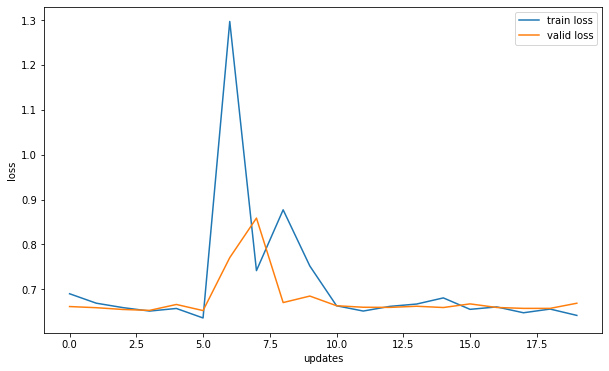

In [158]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax  = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

In [ ]:
# fig = plt.figure(figsize=(10, 6))
# ax  = fig.add_subplot(1, 1, 1)
# ax.plot(train_accs, label = 'train acc')
# ax.plot(valid_accs, label = 'valid acc')
# plt.legend()
# ax.set_xlabel('updates')
# ax.set_ylabel('acc')

In [ ]:
model.load_state_dict(torch.load('./models/StressLSTMv2.pt'))
test_loss, test_acc = evaluate(model, test_loader, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')